In [ ]:
!unzip "/content/drive/MyDrive/Data/archive.zip" -d "/content/gtsrb-german-traffic-sign/"

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00011.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00012.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00013.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00014.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00015.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00016.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00017.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00018.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00019.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00020.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00021.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_0

In [ ]:

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn import metrics
from sklearn.metrics import classification_report
from skimage import feature


import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Conv2D , MaxPool2D 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
dataset_directory = os.path.join(os.getcwd(), 'gtsrb-german-traffic-sign')
train_path = os.path.join(dataset_directory, 'Train')
train_path

'/content/gtsrb-german-traffic-sign/Train'

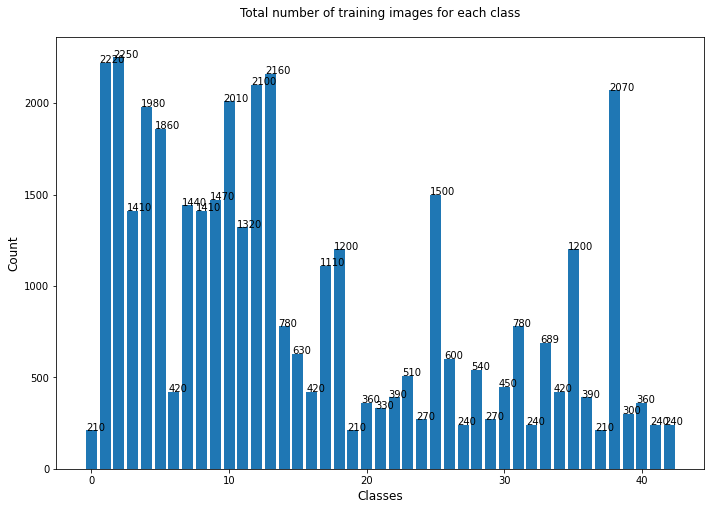

In [ ]:
df_train = pd.read_csv(os.path.join(dataset_directory, "Train.csv"))
df_train.head()
unique_class, counts_class = np.unique(df_train["ClassId"], return_counts=True)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.bar(unique_class,counts_class)
ax.set_xlabel('Classes', fontsize='large')
ax.set_ylabel('Count', fontsize='large')
ax.set_title('Total number of training images for each class', fontsize='large', pad=20)
for i in ax.patches:
    ax.text(i.get_x(), i.get_height()+.03,str(round((i.get_height()), 1)), fontsize=10,color='black')
plt.show()

In [ ]:
image_data = []
image_labels = []
for row in df_train.iterrows():
    path = os.path.join(dataset_directory, row[1][7])
    img = cv2.imread(path)
    cropped_img=img[int(row[1][3]): int(row[1][5]), int(row[1][2]): int(row[1][4])]
    image_f = Image.fromarray(cropped_img, 'RGB')
    size_image = image_f.resize((40, 40))
    image_data.append(np.array(size_image))
    image_labels.append(row[1][6])
        
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)


(39209, 40, 40, 3) (39209,)


In [ ]:
X_resampled= image_data
y_resampled=image_labels

In [ ]:

# shuffle_indexes = np.arange(image_data.shape[0])
# np.random.shuffle(shuffle_indexes)
# image_data = image_data[shuffle_indexes]
# image_labels = image_labels[shuffle_indexes]
X_train, X_val, y_train, y_val = train_test_split(X_resampled, 
                                                  y_resampled, 
                                                  test_size=0.3, 
                                                  random_state=42, 
                                                  shuffle=True
                                                  )



print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)
X_val=X_val/255

X_train.shape (27446, 40, 40, 3)
X_valid.shape (11763, 40, 40, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [ ]:
augment = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=10,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")
augment.fit(X_train)

In [ ]:
model =Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(40,40,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(43, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 38, 38, 16)        448       
                                                                 
 conv2d_9 (Conv2D)           (None, 36, 36, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 18, 18, 32)       128       
 hNormalization)                                                 
                                                                 
 flatten_3 (Flatten)         (None, 10368)             0         
                                                                 
 dense_6 (Dense)             (None, 512)              

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:

history = H = model.fit(augment.flow(X_train, y_train, batch_size=32),
	validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 32,
	epochs=25)

Epoch 1/25
857/857 [==============================] - 140s 162ms/step - loss: 1.0539 - accuracy: 0.7015 - val_loss: 0.3116 - val_accuracy: 0.8922
Epoch 2/25
857/857 [==============================] - 137s 160ms/step - loss: 0.3456 - accuracy: 0.8938 - val_loss: 0.0813 - val_accuracy: 0.9796
Epoch 3/25
857/857 [==============================] - 137s 160ms/step - loss: 0.2277 - accuracy: 0.9316 - val_loss: 0.1018 - val_accuracy: 0.9686
Epoch 4/25
857/857 [==============================] - 137s 160ms/step - loss: 0.1755 - accuracy: 0.9442 - val_loss: 0.0425 - val_accuracy: 0.9901
Epoch 5/25
857/857 [==============================] - 137s 160ms/step - loss: 0.1457 - accuracy: 0.9552 - val_loss: 0.0489 - val_accuracy: 0.9855
Epoch 6/25
857/857 [==============================] - 136s 159ms/step - loss: 0.1252 - accuracy: 0.9612 - val_loss: 0.0970 - val_accuracy: 0.9693
Epoch 7/25
857/857 [==============================] - 137s 160ms/step - loss: 0.1294 - accuracy: 0.9589 - val_loss: 0.0275 -

In [ ]:
# model = keras.models.load_model('CNNpara')
# from tensorflow import keras
# model = keras.models.load_model('CNNpara')

In [ ]:
model.save("my_h5_model.h5")
model = keras.models.load_model("my_h5_model.h5")

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [ ]:
df_test = pd.read_csv(os.path.join(dataset_directory, "Test.csv"))
X_test = []
y_test = []
for row in df_test.iterrows():
    path = os.path.join(dataset_directory, row[1][7])
    img = cv2.imread(path)
    cropped_img=img[int(row[1][3]): int(row[1][5]), int(row[1][2]): int(row[1][4])]
    image_f = Image.fromarray(cropped_img, 'RGB')
    size_image = image_f.resize((40, 40))
    X_test.append(np.array(size_image))
    y_test.append(row[1][6])
        
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_test.shape, y_test.shape)
X_test = X_test/255


predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
from sklearn.metrics import accuracy_score
print('Test accuracy: ',accuracy_score(y_test, classes_x)*100)

(12630, 40, 40, 3) (12630,)
Test accuracy:  97.08630245447347


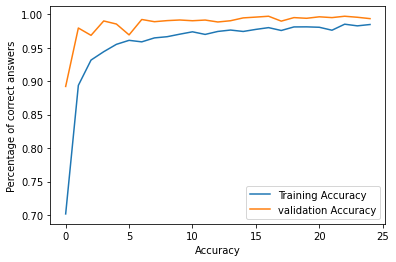

In [ ]:
plt.plot(history.history['accuracy'], 
         label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 
         label='validation Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Percentage of correct answers')
plt.legend()
plt.show()

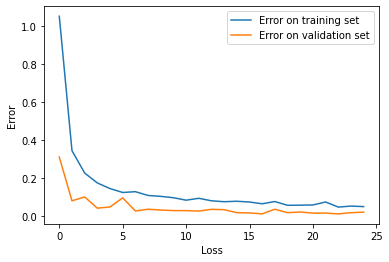

In [ ]:
plt.plot(history.history['loss'], 
         label='Error on training set')
plt.plot(history.history['val_loss'], 
         label='Error on validation set')
plt.xlabel('Loss')
plt.ylabel('Error')
plt.legend()
plt.show()

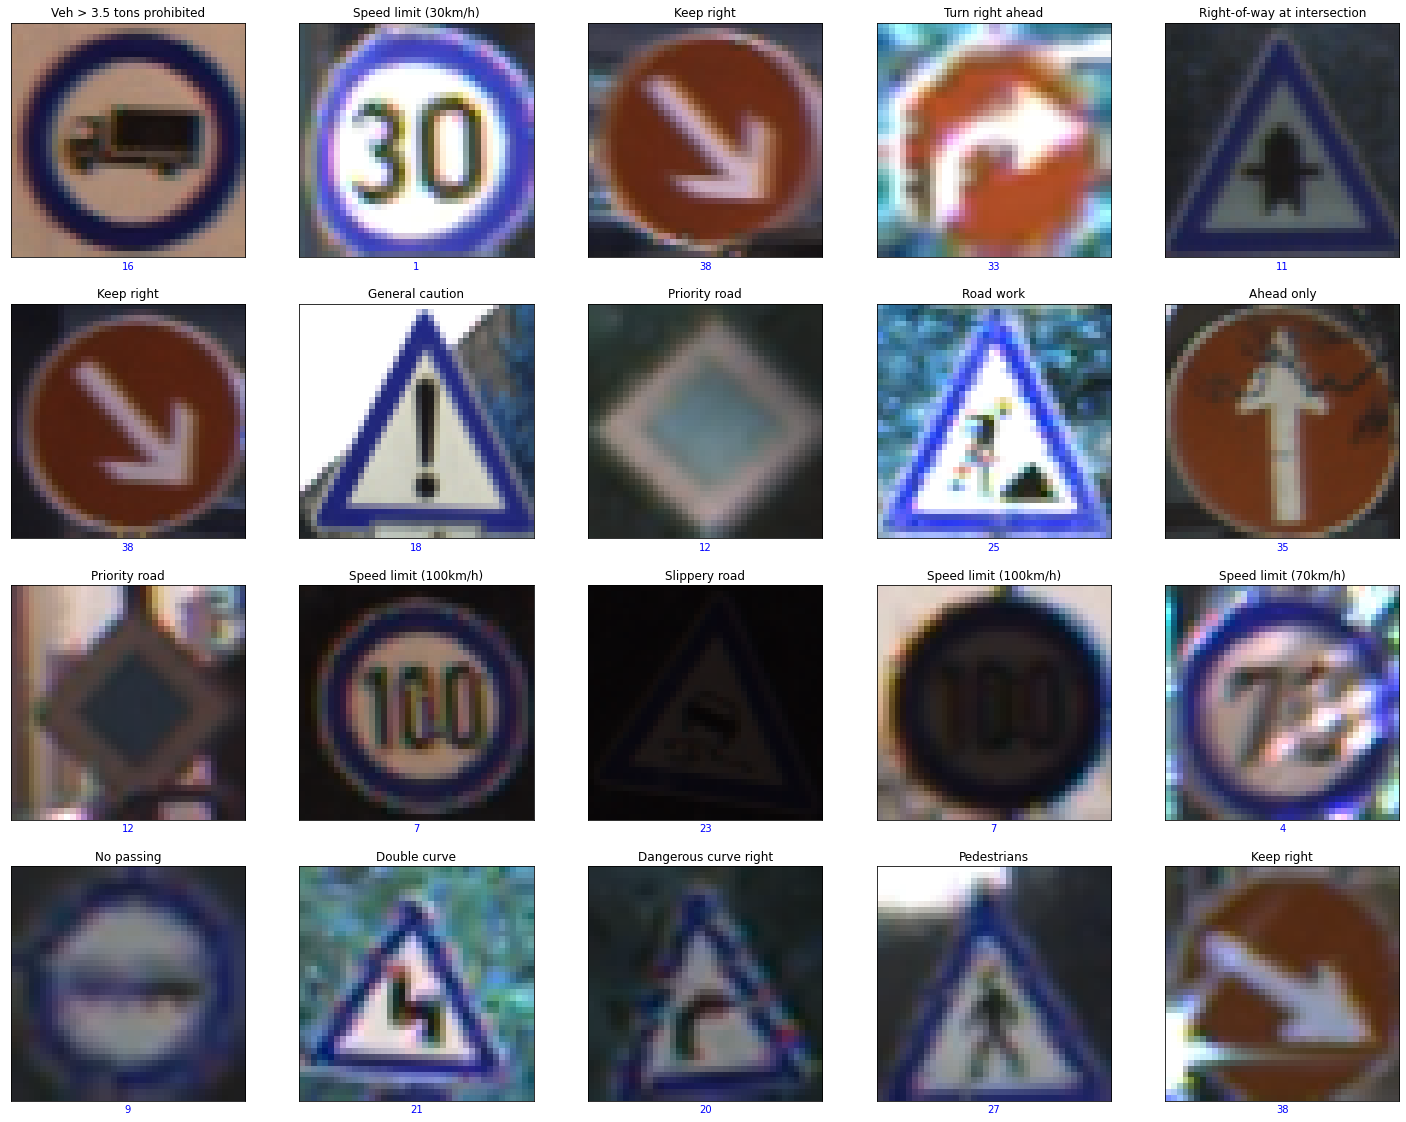

In [ ]:
plt.figure(figsize = (25, 25))
start_index = 0
for i in range(20):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = classes_x[start_index + i]
    actual = y_test[start_index + i]
    col = 'b'
    if prediction != actual:
        col = 'r'
    plt.xlabel(prediction, color = col)
    plt.title(classes[y_test[i]])
    plt.imshow(X_test[start_index + i])
plt.show()

In [ ]:

from sklearn.metrics import classification_report
print(classification_report(y_test, classes_x))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        60
           1       0.95      0.99      0.97       720
           2       1.00      0.96      0.98       750
           3       0.98      0.91      0.95       450
           4       0.99      0.98      0.99       660
           5       0.90      0.99      0.94       630
           6       1.00      0.86      0.92       150
           7       0.99      0.99      0.99       450
           8       0.98      0.96      0.97       450
           9       0.99      1.00      0.99       480
          10       1.00      1.00      1.00       660
          11       0.92      1.00      0.96       420
          12       1.00      0.98      0.99       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       0.98      1.00      0.99       210
          16       0.98      0.99      0.99       150
          17       0.99    